# Projeto de análise de sentimentos

Esse projeto consiste em uma analise preditiva de uma base de dados com diversos comentários do IMDb que foram analisados como comentários positivos ou negativos, com base dessa análise é criado um modelo para classificar um comentário de forma totalmente automática.

In [2]:
 #Importando as bibliotecas necessárias
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import nltk
 import re
 from catboost import CatBoostClassifier
 from nltk.corpus import stopwords
 from nltk.tokenize import word_tokenize
 from nltk.stem import SnowballStemmer
 from sklearn.feature_extraction.text import CountVectorizer
 from sklearn.model_selection import train_test_split
 from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.tree import DecisionTreeClassifier
 from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
 import pickle

In [3]:
#Importando uma base de dados e a tranformando em um dataframe
path = 'data\IMDB-Dataset.csv'
df = pd.read_csv(path)

# Analise exploratória de dados

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df[df['sentiment'] == 'positive'].count()

review       25000
sentiment    25000
dtype: int64

In [7]:
df[df['sentiment'] == 'negative'].count()

review       25000
sentiment    25000
dtype: int64

In [8]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

# Limpeza de dados para que possa ser usado no modelo

In [9]:
def text_clear(text):
  cleaned = re.compile(r'<.*?>')
  return re.sub(cleaned, '', text)

df.review = df.review.apply(text_clear)
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [10]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
          rem = rem + i
        else:
          rem = rem + ' '
    return rem

df['review']= df['review'].apply(is_special)
df['review'][0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [11]:
def to_lower(text):
  return text.lower()

df['review'] = df['review'].apply(to_lower)
df['review'][0]

'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

# Usando a biblioteca nltk para trabalhar com o texto ja organizado e tratado anteriormente

In [12]:
nltk.download('stopwords')
nltk.download('punkt')


def rem_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [w for w in words if w not in stop_words]

df['review'] = df['review'].apply(rem_stopwords)
df['review'][0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Suporte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Suporte\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['one',
 'reviewers',
 'mentioned',
 'watching',
 '1',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'shows',
 'da

In [13]:
def stem_txt(text):
  ss = SnowballStemmer('english')
  return " ".join([ss.stem(w) for w in text])

df['review'] = df['review'].apply(stem_txt)
df['review'][0]

'one review mention watch 1 oz episod hook right exact happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

# Criando as variáveis de treino e de teste para serem usadas nos modelos preditivos

In [14]:
x = np.array(df.iloc[:,0].values)
y = np.array(df['sentiment'].values)
cv = CountVectorizer(max_features=1000)
x = cv.fit_transform(df['review']).toarray()

print(x.shape)
print(y.shape)

(50000, 1000)
(50000,)


In [15]:
x_train, x_test, y_train, y_test= train_test_split(x,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 9)

#Configurando e treinando os modelos preditivos

In [16]:
gnb,mnb,bnb = GaussianNB(), MultinomialNB(alpha=1.0, fit_prior= True), BernoulliNB(alpha = 1.0, fit_prior = True)

gnb.fit(x_train, y_train)
mnb.fit(x_train, y_train)
bnb.fit(x_train, y_train)

BernoulliNB()

In [17]:
arvore_decisão = DecisionTreeClassifier(criterion = 'entropy')
arvore_decisão.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [32]:
model = CatBoostClassifier(iterations=2, learning_rate=1, depth=2)
model.fit(x_train, y_train)

0:	learn: 0.6219923	total: 189ms	remaining: 189ms
1:	learn: 0.5777951	total: 226ms	remaining: 0us


In [33]:
ypcat = model.predict(x_test)

In [18]:
ypg = gnb.predict(x_test)
ypm = mnb.predict(x_test)
ypb = bnb.predict(x_test)

In [19]:
adp = arvore_decisão.predict(x_test)

# Analisando os modelos treinando e sua acurácia

In [20]:
print('Gaussian: ', accuracy_score(y_test,ypg))
print('MultinominalNB: ',accuracy_score(y_test, ypm))
print('BernoulliNB: ', accuracy_score(y_test, ypb))

Gaussian:  0.7843
MultinominalNB:  0.831
BernoulliNB:  0.8386


In [21]:
print("Decision Tree Classifier: ", accuracy_score(y_test, adp))

Decision Tree Classifier:  0.7216


In [34]:
print("CatBoostClassifier:", accuracy_score(y_test,ypcat))

CatBoostClassifier: 0.6862


In [22]:
cmg = confusion_matrix(y_test,ypg)
cmm = confusion_matrix(y_test,ypm)
cmb = confusion_matrix(y_test,ypb)


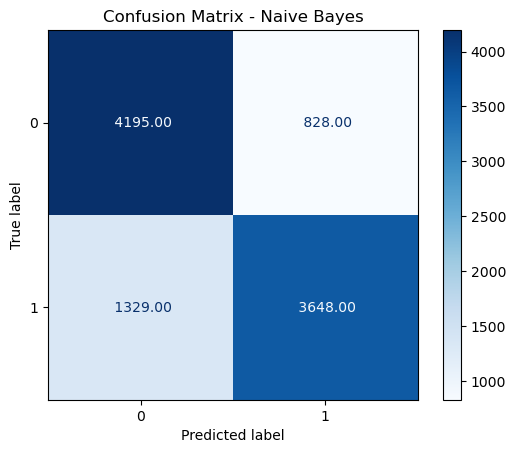

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cmg, display_labels=[0,1])
disp.plot(cmap = 'Blues', values_format = ' .2f')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

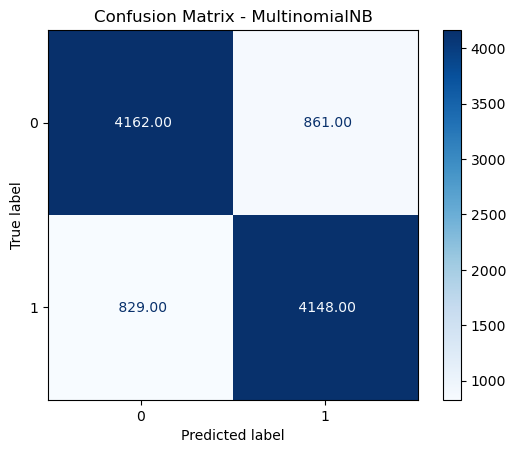

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cmm, display_labels=[0,1])
disp.plot(cmap = 'Blues', values_format = ' .2f')
plt.title("Confusion Matrix - MultinomialNB")
plt.show()

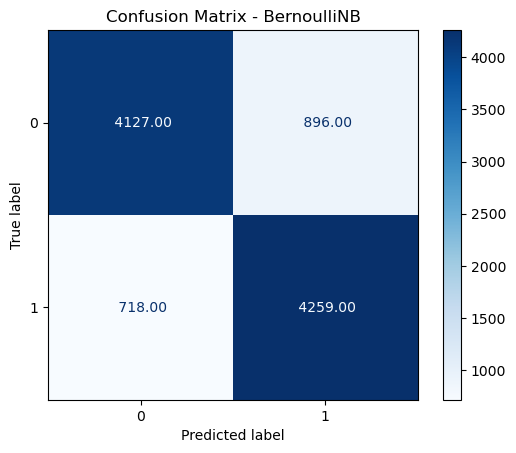

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cmb, display_labels=[0,1])
disp.plot(cmap = 'Blues', values_format = ' .2f')
plt.title("Confusion Matrix - BernoulliNB")
plt.show()

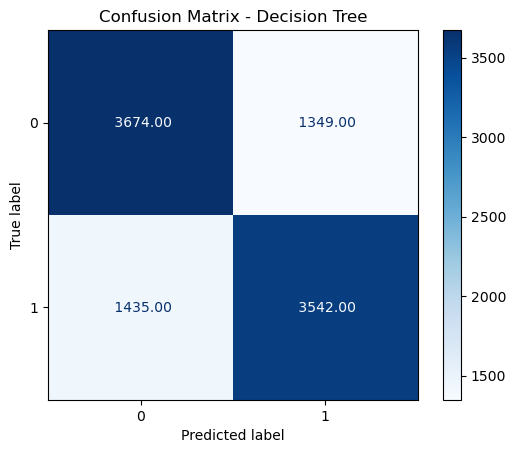

In [26]:
cad = confusion_matrix(y_test,adp)
disp = ConfusionMatrixDisplay(confusion_matrix = cad, display_labels=[0,1])
disp.plot(cmap= 'Blues', values_format= ' .2f')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

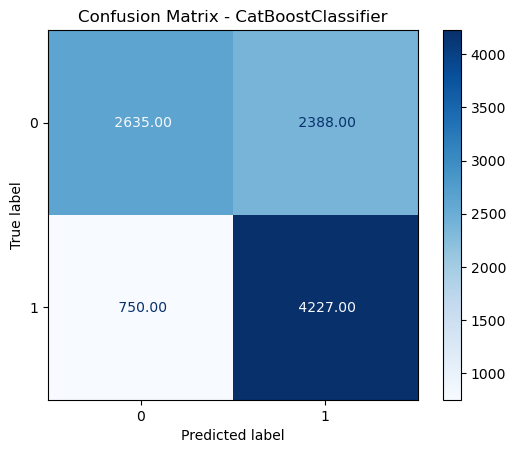

In [35]:
ccat = confusion_matrix(y_test,ypcat)
disp = ConfusionMatrixDisplay(confusion_matrix = ccat, display_labels = [0,1])
disp.plot(cmap= 'Blues', values_format= ' .2f')
plt.title("Confusion Matrix - CatBoostClassifier")
plt.show()

Com essa análise percebemos que o melhor modelo para predição dessa base de dados é o BernoulliNB, com isso vamos exportar esse melhor modelo como um arquivo .pkl para podermos usar futuramente.

In [27]:
pickle.dump(bnb, open('model1.pkl', 'wb'))

#Teste de modelo aicionando um novo comentário e analisando sua classificação(positivo ou negativo)

In [28]:
rev = """The Marvels is so poorly conceived and ineptly executed that it not
only makes this a front-runner for the dubious honor of worst movie of the MCU
but a contender for the worst superhero movie of all time."""

f1 = text_clear(rev)
f2 = is_special(f1)
f3 = to_lower(f2)
f4 = rem_stopwords(f3)
f5 = stem_txt(f4)

In [29]:
bow,words = [], word_tokenize(f5)

for word in words:
  bow.append(words.count(word))

word_dict = cv.vocabulary_
pickle.dump(word_dict,open('bow.pkl', 'wb'))

In [30]:
inp = []

for i in word_dict:
  inp.append(f5.count(i[0]))

y_pred = bnb.predict(np.array(inp).reshape(1,1000))

In [31]:
y_pred

array(['negative'], dtype='<U8')